In [51]:
using DataFrames, CSV, Dates, Measures, Statistics, StatsPlots, IterativeSolvers, Polynomials, DelimitedFiles

In [105]:
function get_macro(case_name;path = "")
    results = Dict()
    critical = 222:311
    generators = [
        "paraibuna",
        "simplicio",
        "sta_branca",
        "jaguari",
        "ilha_dos_pombos",
        "funil",
        "sobragi",
        "fontes_a",
        "fontes_bc",
        "nilo_pecanha",
        "picada",
        "pereira_passos"
    ]
    light = [
        "simplicio",
        "ilha_dos_pombos",
        "sobragi",
        "fontes_a",
        "fontes_bc",
        "nilo_pecanha",
        "picada",
        "pereira_passos"
        ]
    plants = vcat(generators, ["lajes","santana","sta_cecilia","tocos","vigario"])
    df_generation = DataFrame(CSV.File(joinpath(path,case_name,"results",case_name*"_generation_MW.csv")))
    results["total_generation"] = sum(mean.(eachcol(df_generation[:,generators])))
    results["light_generation"] = sum(mean.(eachcol(df_generation[:,light])))
    results["total_generation_critical"] = sum(mean.(eachcol(df_generation[critical,generators])))
    results["light_generation_critical"] = sum(mean.(eachcol(df_generation[critical,light])))
    results["ps_average_reservoir"] = mean(df_generation[:,"ps_equivalent_reservoir"])
    results["ps_average_reservoir_critical"] = mean(df_generation[critical,"ps_equivalent_reservoir"])
    df_spillage = DataFrame(CSV.File(joinpath(path,case_name,"results",case_name*"_spillage_m3_per_sec.csv")))
    total_spillage = sum(sum.(eachcol(df_spillage[:,plants])))
    results["total_spillage"] = total_spillage
    total_spillage_critical = sum(sum.(eachcol(df_spillage[critical,plants])))
    df_turbining = DataFrame(CSV.File(joinpath(path,case_name,"results",case_name*"_turbining_m3_per_sec.csv")))
    total_turbining = sum(sum.(eachcol(df_turbining[:,plants])))
    total_turbining_critical = sum(sum.(eachcol(df_turbining[critical,plants])))
    results["turbining_ratio"] = total_turbining/(total_turbining + total_spillage)
    results["turbining_ratio_critical"] = total_turbining_critical/(total_turbining_critical + total_spillage_critical)
    df_turbining_violations = DataFrame(CSV.File(joinpath(path,case_name,"results","violations",case_name*"_turbining_violations_m3_per_sec.csv")))
    results["total_turbining_violations"] = sum(sum.(eachcol(df_turbining_violations[:,plants])))
    if case_name == "base_results"
        results["params"] = case_name
    else
        A = case_name[findfirst("_",case_name)[1]+1:findnext("_",case_name,7)[1]-1]
        B = case_name[findnext("_",case_name,7)[1]+1:findlast("%",case_name)[1]-1]
        B = parse(Int64,B)/100
        C = case_name[findlast("_",case_name)[1]+1:end]
        results["params"] = "($(A), $(B), $(C))"
    end
    return results
end

get_macro (generic function with 1 method)

In [106]:
name = "base_results"
results = get_macro(name)
results["name"] = name
df = DataFrame(results)
trials = "function_trials"
for trial in readdir(trials)
    results = get_macro(trial,path = trials)
    results["name"] = trial
    append!(df,results)
end
df[:,"params"]

65-element Vector{String}:
 "base_results"
 "(130, 0.0, 2.0)"
 "(130, 1.0, 0.5)"
 "(130, 1.0, 1.0)"
 "(130, 1.0, 1.5)"
 "(130, 1.0, 2.0)"
 "(130, 0.2, 1.5)"
 "(130, 0.2, 2.0)"
 "(130, 0.4, 1.5)"
 "(130, 0.4, 2.0)"
 "(130, 0.6, 1.0)"
 "(130, 0.6, 1.5)"
 "(130, 0.6, 2.0)"
 ⋮
 "(190, 1.0, 2.0)"
 "(190, 0.2, 1.5)"
 "(190, 0.2, 2.0)"
 "(190, 0.4, 1.5)"
 "(190, 0.4, 2.0)"
 "(190, 0.6, 1.0)"
 "(190, 0.6, 1.5)"
 "(190, 0.6, 2.0)"
 "(190, 0.8, 0.5)"
 "(190, 0.8, 1.0)"
 "(190, 0.8, 1.5)"
 "(190, 0.8, 2.0)"

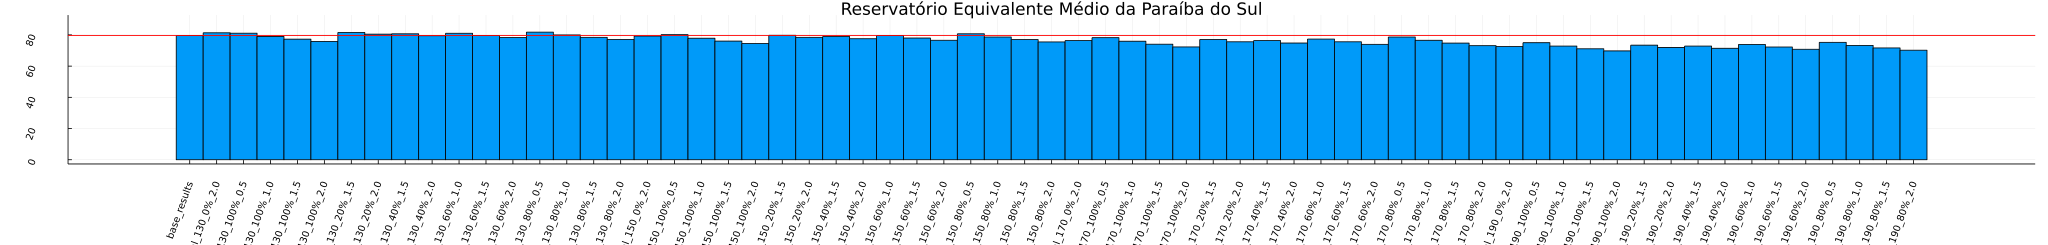

In [54]:
bar(df[!,"name"],100*df[!,"ps_average_reservoir"],
    bar_width = 1,
    ylim = [0,90],
    rot = 70,
    xticks = :all,
    size = (2500,300),
    bottom_margin = 18mm,
    left_margin = 5mm,
    title = "Reservatório Equivalente Médio da Paraíba do Sul",
    ylabel = "(%)",
    legend = false
)
p = plot!([df[1,"ps_average_reservoir"]*100], seriestype="hline",color=:red)
#annotate!(-0.16, df[1,"ps_average_reservoir"], text("160", :red, 6))

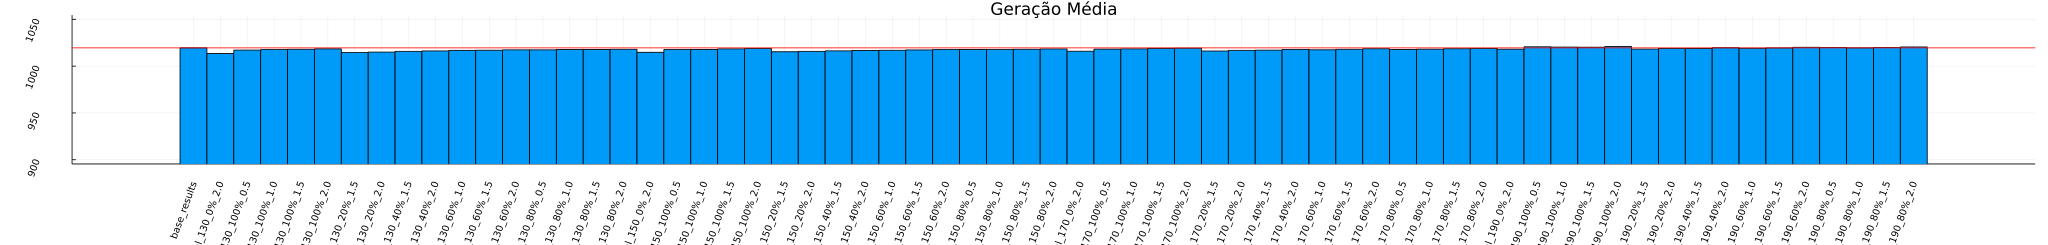

In [66]:
bar(df[!,"name"],df[!,"total_generation"],
    bar_width = 1,
    ylim = [900,1050],
    rot = 70,
    xticks = :all,
    size = (2500,300),
    bottom_margin = 18mm,
    left_margin = 5mm,
    title = "Geração Média",
    ylabel = "MWm",
    legend = false
)

p = plot!([df[1,"total_generation"]], seriestype="hline",color=:red)

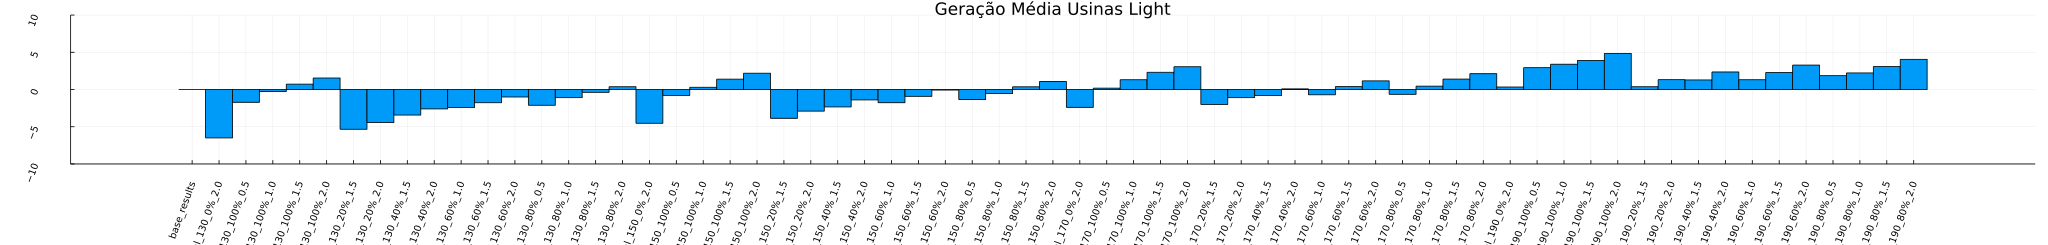

In [64]:
bar(df[!,"name"],df[!,"light_generation"] .- df[1,"light_generation"],
    bar_width = 1,
    rot = 70,
    ylim = (-10,10),
    xticks = :all,
    size = (2500,300),
    bottom_margin = 18mm,
    left_margin = 5mm,
    title = "Geração Média Usinas Light",
    ylabel = "MWm",
    legend = false
)

p = plot!([df[1,"light_generation"]], seriestype="hline",color=:red)

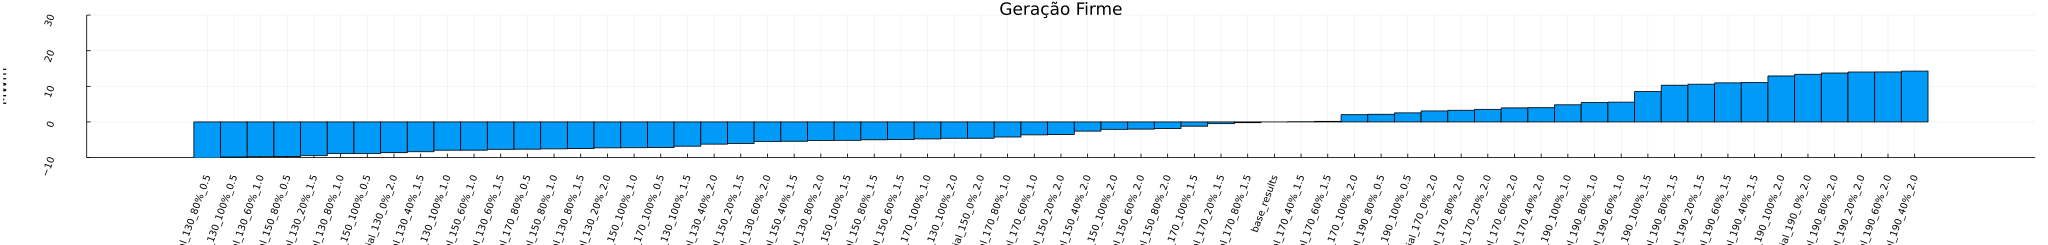

In [68]:
base = df[1,"total_generation_critical"]
sorted_df = sort(df,[:total_generation_critical])

bar(sorted_df[!,"name"],sorted_df[!,"total_generation_critical"] .- base,
    bar_width = 1,
    rot = 70,
    ylim = (-10,30),
    xticks = :all,
    size = (2500,300),
    bottom_margin = 20mm,
    left_margin = 10mm,
    title = "Geração Firme",
    ylabel = "MWm",
    legend = false
)

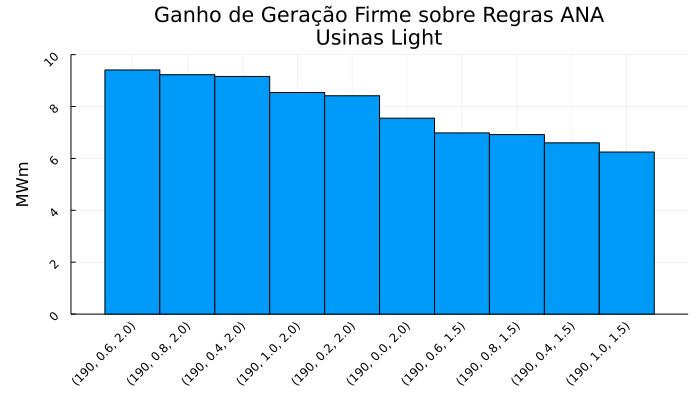

In [111]:
base = df[1,"light_generation_critical"]
sorted_df = sort(df,[:light_generation_critical], rev = true)
sorted_df = first(sorted_df,10)
p = bar(sorted_df[!,"params"],sorted_df[!,"light_generation_critical"] .- base,
    bar_width = 1,
    rot = 45,
    ylim = (0,10),
    xticks = :all,
    size = (700,400),
    bottom_margin = 8mm,
    left_margin = 5mm,
    title = "Ganho de Geração Firme sobre Regras ANA\nUsinas Light\n",
    ylabel = "MWm",
    legend = false
)

savefig(joinpath("figures","critical_light.png"))
p

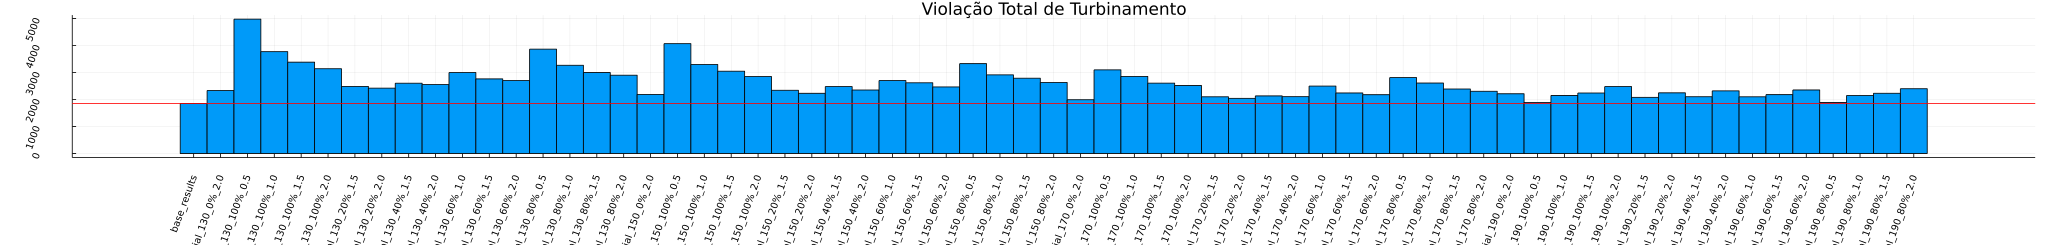

In [58]:
bar(df[!,"name"],df[!,"total_turbining_violations"],
    bar_width = 1,
    rot = 70,
    xticks = :all,
    size = (2500,300),
    bottom_margin = 20mm,
    left_margin = 5mm,
    title = "Violação Total de Turbinamento",
    ylabel = "m^3",
    legend = false
)

p = plot!([df[1,"total_turbining_violations"]], seriestype="hline",color=:red)

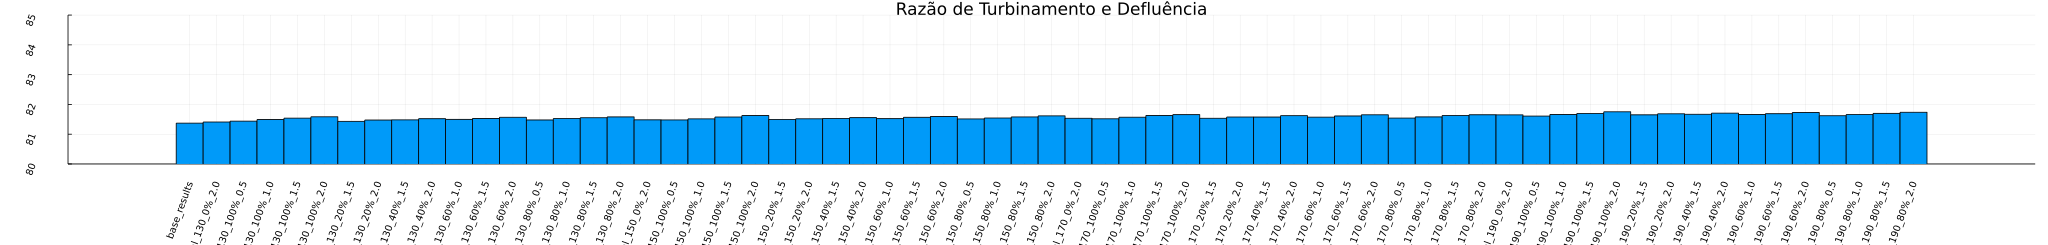

In [59]:
bar(df[!,"name"],100*(df[!,"turbining_ratio"]),
    bar_width = 1,
    rot = 70,
    xticks = :all,
    ylim = (80,85),
    size = (2500,300),
    bottom_margin = 18mm,
    left_margin = 5mm,
    title = "Razão de Turbinamento e Defluência",
    ylabel = "%",
    legend = false
)

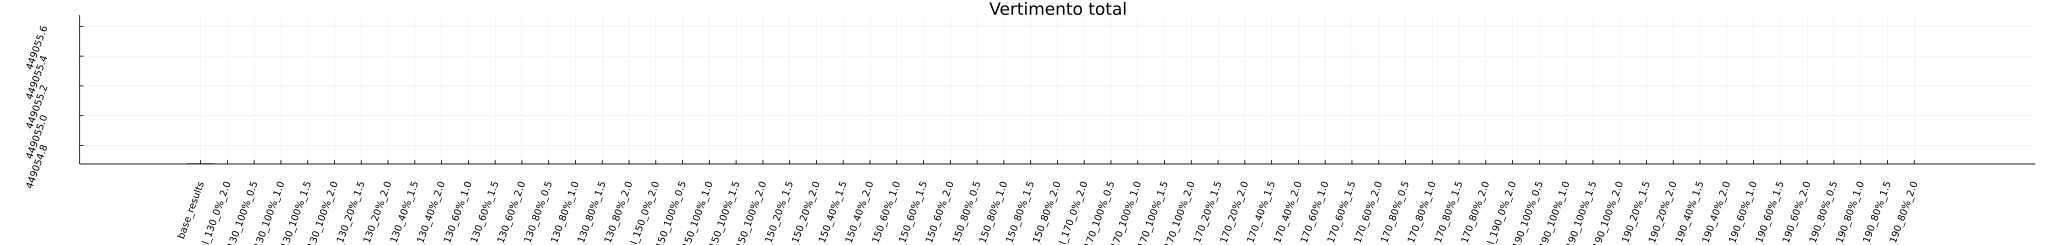

In [60]:
bar(df[!,"name"],(df[!,"total_spillage"]),
    bar_width = 1,
    rot = 70,
    xticks = :all,
    ylim = (maximum(df[!,"total_spillage"]),minimum(df[!,"total_spillage"])),
    size = (2500,300),
    bottom_margin = 18mm,
    left_margin = 5mm,
    title = "Vertimento total",
    ylabel = "m^3/s",
    legend = false
)

In [61]:
df[!,"total_spillage"]

65-element Vector{Float64}:
 449054.6756981677
 447222.58321093395
 446789.16987498454
 445860.680777775
 444946.5256125117
 444078.892450617
 446733.87926308124
 445912.64285331394
 445776.28205193847
 445055.90492840763
 445394.2391491309
 444843.70813251595
 444128.024842455
      ⋮
 441091.6079285826
 443056.4631833016
 442518.44268955785
 442686.1460520607
 442075.23477921163
 442789.0835727534
 442327.88334991405
 441642.6003305675
 443646.1998086469
 442848.8568396804
 442101.6139770515
 441457.80136244115

In [62]:
CSV.write("trial_results_compiled.csv",df)

"trial_results_compiled.csv"